<a href="https://colab.research.google.com/github/Semi-technical/AI-Meme-Generator/blob/main/Fake_News_Detection_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Fake News Detection - Machine Learning Project
# Suitable for Google Colab

# Step 1: Install required libraries
!pip install pandas numpy scikit-learn matplotlib seaborn wordcloud

In [ ]:
# Step 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [ ]:
# Step 3: Load Dataset from Google Drive (ENHANCED)
print("\n📊 Loading Dataset from Google Drive...")

from google.colab import drive
drive.mount('/content/drive')
print("✓ Google Drive mounted successfully!")

# Load files
fake_df = pd.read_csv('/content/drive/MyDrive/my_folder/Fake.csv')
true_df = pd.read_csv('/content/drive/MyDrive/my_folder/True.csv')

print(f"\n📋 Fake.csv columns: {fake_df.columns.tolist()}")
print(f"📋 True.csv columns: {true_df.columns.tolist()}")

print(f"\n✓ Fake news loaded: {len(fake_df)} articles")
print(f"✓ True news loaded: {len(true_df)} articles")

# Assign labels
fake_df['label'] = 1  # Fake = 1
true_df['label'] = 0  # True = 0

# Combine datasets
df = pd.concat([fake_df, true_df], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Create text column from title (most datasets use 'title')
if 'title' in df.columns:
    df['text'] = df['title'].fillna('')
    if 'text' in fake_df.columns:  # If there's also a text column
        df['text'] = df['title'] + " " + df.get('text', '').fillna('')
    print("✓ Using 'title' column as text")

# Verify the data
print(f"\n✅ Final dataset: {len(df)} articles")
print("\nLabel distribution:")
print(df['label'].value_counts())
print("\nSample data:")
print(df[['text', 'label']].head(3))


📊 Loading Dataset from Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted successfully!

📋 Fake.csv columns: ['title', 'text', 'subject', 'date']
📋 True.csv columns: ['title', 'text', 'subject', 'date']

✓ Fake news loaded: 23481 articles
✓ True news loaded: 21417 articles
✓ Using 'title' column as text

✅ Final dataset: 44898 articles

Label distribution:
label
1    23481
0    21417
Name: count, dtype: int64

Sample data:
                                                text  label
0  Ben Stein Calls Out 9th Circuit Court: Committ...      1
1  Trump drops Steve Bannon from National Securit...      0
2  Puerto Rico expects U.S. to lift Jones Act shi...      0



📈 DATA EXPLORATION

Dataset Info:
Total samples: 44898
Columns: ['title', 'text', 'subject', 'date', 'label']

Missing values:
title      0
text       0
subject    0
date       0
label      0
dtype: int64

Label Distribution:
label
1    23481
0    21417
Name: count, dtype: int64


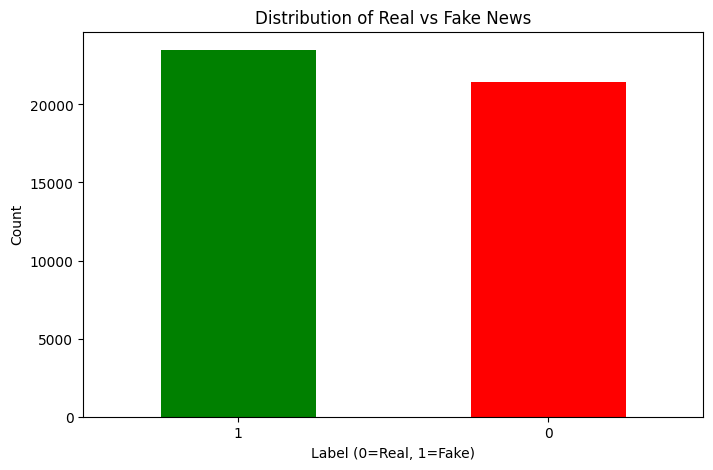

In [ ]:
# Step 4: Data Exploration
print("\n" + "="*50)
print("📈 DATA EXPLORATION")
print("="*50)

print(f"\nDataset Info:")
print(f"Total samples: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nMissing values:")
print(df.isnull().sum())

# Check label distribution
print(f"\nLabel Distribution:")
print(df['label'].value_counts())

# Visualize label distribution
plt.figure(figsize=(8, 5))
df['label'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Distribution of Real vs Fake News')
plt.xlabel('Label (0=Real, 1=Fake)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Step 5: Text Preprocessing
print("\n" + "="*50)
print("🔧 TEXT PREPROCESSING")
print("="*50)

def preprocess_text(text):
    """Clean and preprocess text data"""
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove user mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Apply preprocessing
df['cleaned_text'] = df['text'].apply(preprocess_text)
print("✓ Text preprocessing completed!")

# Show example
print(f"\nExample of preprocessing:")
print(f"Original: {df['text'].iloc[0][:100]}...")
print(f"Cleaned: {df['cleaned_text'].iloc[0][:100]}...")


🔧 TEXT PREPROCESSING
✓ Text preprocessing completed!

Example of preprocessing:
Original: Ben Stein Calls Out 9th Circuit Court: Committed a ‘Coup d’état’ Against the Constitution Ben Stein ...
Cleaned: ben stein calls out 9th circuit court committed a ‘coup d’état’ against the constitution ben stein c...



📊 Generating Word Clouds...


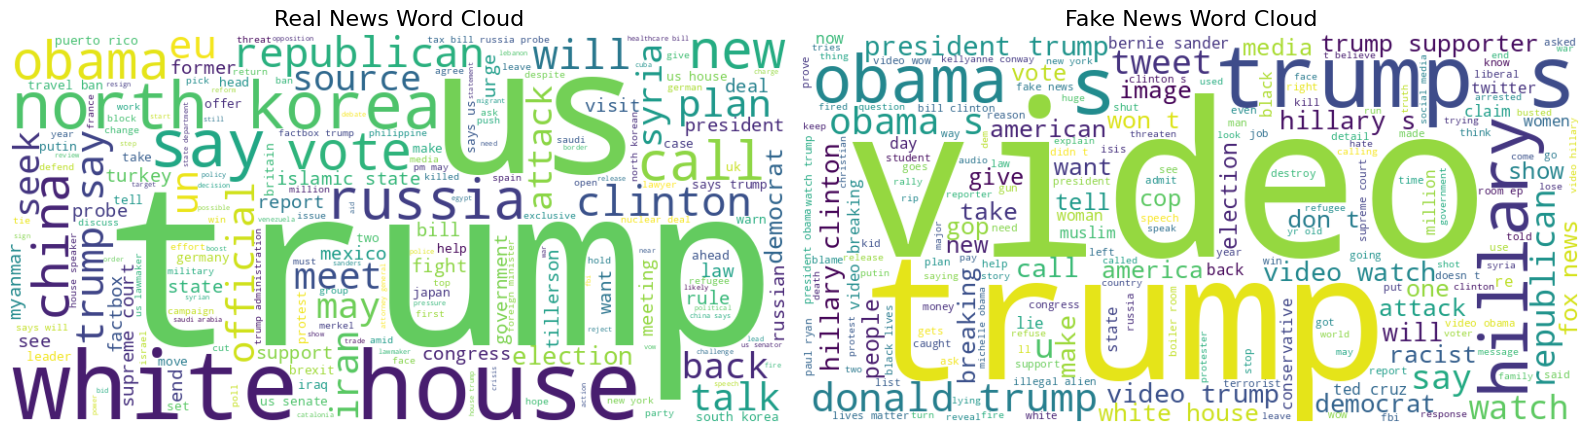

In [ ]:
# Step 6: Word Cloud Visualization
print("\n📊 Generating Word Clouds...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Word cloud for Real news
real_text = ' '.join(df[df['label'] == 0]['cleaned_text'])
wc_real = WordCloud(width=800, height=400, background_color='white').generate(real_text)
axes[0].imshow(wc_real, interpolation='bilinear')
axes[0].set_title('Real News Word Cloud', fontsize=16)
axes[0].axis('off')

# Word cloud for Fake news
fake_text = ' '.join(df[df['label'] == 1]['cleaned_text'])
wc_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
axes[1].imshow(wc_fake, interpolation='bilinear')
axes[1].set_title('Fake News Word Cloud', fontsize=16)
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Step 7: Feature Extraction using TF-IDF
print("\n" + "="*50)
print("🔤 FEATURE EXTRACTION")
print("="*50)

# Split data
X = df['cleaned_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"✓ TF-IDF vectorization completed!")
print(f"Feature matrix shape: {X_train_tfidf.shape}")


🔤 FEATURE EXTRACTION
Training samples: 35918
Testing samples: 8980
✓ TF-IDF vectorization completed!
Feature matrix shape: (35918, 5000)


In [ ]:
# Step 8: Model Training
print("\n" + "="*50)
print("🤖 MODEL TRAINING")
print("="*50)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"✓ {name} Accuracy: {accuracy:.4f}")


🤖 MODEL TRAINING

Training Logistic Regression...
✓ Logistic Regression Accuracy: 0.9497

Training Naive Bayes...
✓ Naive Bayes Accuracy: 0.9354

Training Decision Tree...
✓ Decision Tree Accuracy: 0.9106



📊 MODEL EVALUATION

🏆 Best Model: Logistic Regression with accuracy 0.9497

📋 Classification Report for Logistic Regression:
              precision    recall  f1-score   support

        Real       0.94      0.95      0.95      4284
        Fake       0.96      0.95      0.95      4696

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



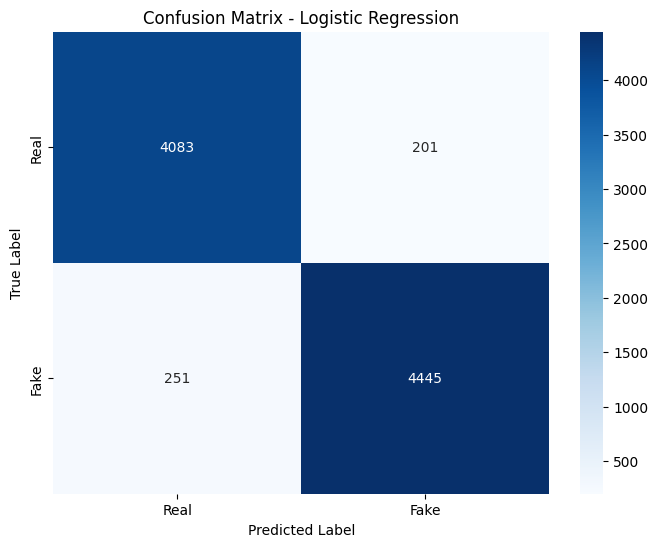

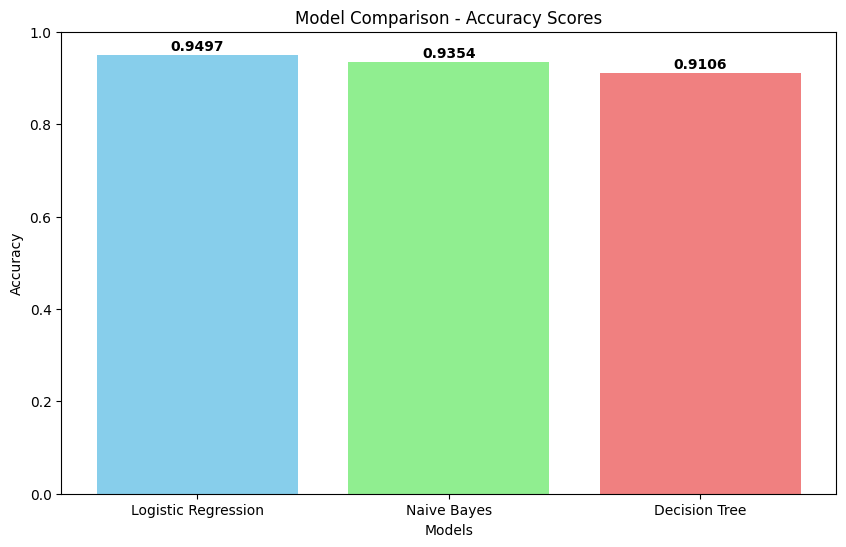

In [ ]:
# Step 9: Model Evaluation
print("\n" + "="*50)
print("📊 MODEL EVALUATION")
print("="*50)

# Find best model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"\n🏆 Best Model: {best_model_name} with accuracy {results[best_model_name]:.4f}")

# Detailed evaluation of best model
y_pred_best = best_model.predict(X_test_tfidf)

print(f"\n📋 Classification Report for {best_model_name}:")
print(classification_report(y_test, y_pred_best, target_names=['Real', 'Fake']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Compare all models
plt.figure(figsize=(10, 6))
models_list = list(results.keys())
accuracies = list(results.values())
colors = ['skyblue', 'lightgreen', 'lightcoral']
plt.bar(models_list, accuracies, color=colors)
plt.title('Model Comparison - Accuracy Scores')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')
plt.show()

In [ ]:
# Step 10: Test with Custom Input
print("\n" + "="*50)
print("🧪 TEST WITH CUSTOM NEWS")
print("="*50)

def predict_news(text):
    """Predict whether a news article is real or fake"""
    cleaned = preprocess_text(text)
    vectorized = tfidf.transform([cleaned])
    prediction = best_model.predict(vectorized)[0]
    probability = best_model.predict_proba(vectorized)[0]

    result = "FAKE NEWS ⚠️" if prediction == 1 else "REAL NEWS ✓"
    confidence = probability[prediction] * 100

    print(f"\nNews: {text[:100]}...")
    print(f"Prediction: {result}")
    print(f"Confidence: {confidence:.2f}%")
    return prediction

# Test examples
test_examples = [
    "Scientists at MIT announce breakthrough in renewable energy technology",
    "BREAKING: You won't believe what celebrities are doing! Click now!!!",
    "Government releases official statistics on economic growth"
]

print("\nTesting sample news articles:")
for example in test_examples:
    predict_news(example)
    print("-" * 50)

# print("\n" + "="*50)
# print("✅ PROJECT COMPLETED SUCCESSFULLY!")
# print("="*50)
# print("\nKey Takeaways:")
# print("1. Loaded and explored the dataset")
# print("2. Preprocessed text data")
# print("3. Extracted features using TF-IDF")
# print("4. Trained multiple ML models")
# print(f"5. Best model: {best_model_name} ({results[best_model_name]:.2%} accuracy)")
# print("6. Evaluated with confusion matrix and classification report")
# print("7. Tested with custom news articles")


🧪 TEST WITH CUSTOM NEWS

Testing sample news articles:

News: Scientists at MIT announce breakthrough in renewable energy technology...
Prediction: REAL NEWS ✓
Confidence: 83.21%
--------------------------------------------------

News: BREAKING: You won't believe what celebrities are doing! Click now!!!...
Prediction: FAKE NEWS ⚠️
Confidence: 99.38%
--------------------------------------------------

News: Government releases official statistics on economic growth...
Prediction: REAL NEWS ✓
Confidence: 93.52%
--------------------------------------------------


In [ ]:
print("\n🔍 INTERACTIVE NEWS TESTING")
print("="*50)

while True:
    print("\nEnter a news headline or article (or type 'quit' to exit):")
    user_input = input("> ")

    if user_input.lower() == 'quit':
        print("Thanks for using the Fake News Detector! 👋")
        break

    if user_input.strip():
        predict_news(user_input)
    else:
        print("Please enter some text!")


🔍 INTERACTIVE NEWS TESTING

Enter a news headline or article (or type 'quit' to exit):
> Bangladesh mourns former leader Khaleda Zia, who died aged 79

News: Bangladesh mourns former leader Khaleda Zia, who died aged 79...
Prediction: REAL NEWS ✓
Confidence: 78.74%

Enter a news headline or article (or type 'quit' to exit):
> HAL’s Dhruv NG multi-role helicopter takes maiden flight in Bengaluru

News: HAL’s Dhruv NG multi-role helicopter takes maiden flight in Bengaluru...
Prediction: REAL NEWS ✓
Confidence: 84.22%

Enter a news headline or article (or type 'quit' to exit):
> PM Modi voices deep concern over targeting of Putin's residence

News: PM Modi voices deep concern over targeting of Putin's residence...
Prediction: REAL NEWS ✓
Confidence: 89.58%

Enter a news headline or article (or type 'quit' to exit):
> Delhi govt refutes reports on stray dog census as "fake news" Read more At:  https://www.aninews.in/news/national/general-news/delhi-govt-refutes-reports-on-stray-dog-census